<a href="https://colab.research.google.com/github/Timure228/Hands-on-ML/blob/main/Chapter_15_Sequences_with_RNNs_CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from pathlib import Path

In [ ]:
path = Path("/content/CTA_-_Ridership_-_Daily_Boarding_Totals_20251009.csv")
df = pd.read_csv(path, parse_dates=["service_date"]) # parse_dates to convert dates in datetime64
df.columns = ["date", "day_type", "bus", "rail", "total"]

In [ ]:
df.sort_values("date").set_index("date")
df = df.drop("total", axis=1) # total is just bus + rail
df = df.drop_duplicates()

In [ ]:
df.head()

date day_type      bus     rail
0 2001-01-01        U  297,192  126,455
1 2001-01-02        W  780,827  501,952
2 2001-01-03        W  824,923  536,432
3 2001-01-04        W  870,021  550,011
4 2001-01-05        W  890,426  557,917

In [ ]:
# turn to int
bus = list(map(lambda x: int(x.replace(",", "")), df["bus"]))
df["bus"] = bus
rail = list(map(lambda x: int(x.replace(",", "")), df["rail"]))
df["rail"] = rail

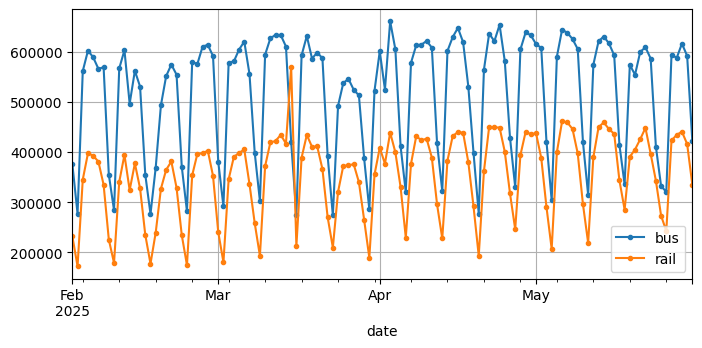

In [ ]:
import matplotlib.pyplot as plt
df.set_index("date").loc['2025-02':'2025-05'].plot(grid=True, marker=".", figsize=(8, 3.5))
plt.show()

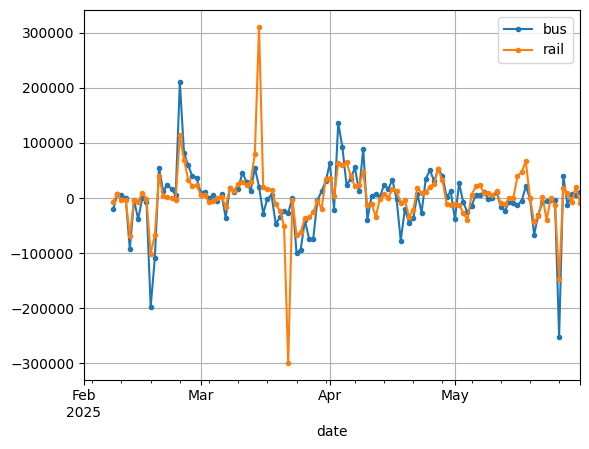

In [ ]:
diff_7 = df.set_index("date")[["bus", "rail"]].loc['2025-02':'2025-05'].diff(7)
diff_7.plot(grid=True, marker=".") # 7-day difference time series
plt.show()

In [ ]:
diff_7.abs().mean()

bus     32590.168142
rail    29204.778761
dtype: float64

In [ ]:
targets = df.set_index("date")[["bus", "rail"]].loc['2025-02':'2025-05']
(diff_7 / targets).abs().mean()

bus     0.067012
rail    0.086752
dtype: float64

In [ ]:
# Forecast for tommorow wit ARIMA model
from statsmodels.tsa.arima.model import ARIMA

origin, today = "2025-01-01", "2025-10-10"
rail_series = df.set_index("date").loc[origin:today]["rail"].asfreq("D") # asfreq to show daily values
model = ARIMA(rail_series,
              order=(1, 0, 0),
              seasonal_order=(0, 1, 1, 7))
model = model.fit()
y_pred = model.forecast()
y_pred

2025-08-01    475628.389179
Freq: D, dtype: float64

In [ ]:
# Make forecast for every day in March, April and May and compute MAE over that period
origin, start_date, end_date = "2025-01-01", "2025-09-01", "2025-10-09"
time_period = pd.date_range(start_date, end_date)
rail_series = df.set_index("date").loc[origin:end_date]["rail"].asfreq("D")
y_preds = []
for today in time_period.shift(-1):
  model = ARIMA(rail_series[origin:today],
              order=(1, 0, 0),
              seasonal_order=(0, 1, 1, 7))
  fitted_model = model.fit() # Note! We retrain the model every day
  y_pred = fitted_model.forecast()[0]
  y_preds.append(y_pred)

y_preds = pd.Series(y_preds, index=time_period)
mae = (y_preds - rail_series[time_period]).abs().mean()
mae

/tmp/ipython-input-2883699452.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = fitted_model.forecast()[0]
/tmp/ipython-input-2883699452.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = fitted_model.forecast()[0]
/tmp/ipython-input-2883699452.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = fitted_model.forecast()[0]
/tmp/ipython-input-2883699452.py:11: FutureWarning: Series.__getitem__ treating

KeyError: "None of [DatetimeIndex(['2025-09-01', '2025-09-02', '2025-09-03', '2025-09-04',\n               '2025-09-05', '2025-09-06', '2025-09-07', '2025-09-08',\n               '2025-09-09', '2025-09-10', '2025-09-11', '2025-09-12',\n               '2025-09-13', '2025-09-14', '2025-09-15', '2025-09-16',\n               '2025-09-17', '2025-09-18', '2025-09-19', '2025-09-20',\n               '2025-09-21', '2025-09-22', '2025-09-23', '2025-09-24',\n               '2025-09-25', '2025-09-26', '2025-09-27', '2025-09-28',\n               '2025-09-29', '2025-09-30', '2025-10-01', '2025-10-02',\n               '2025-10-03', '2025-10-04', '2025-10-05', '2025-10-06',\n               '2025-10-07', '2025-10-08', '2025-10-09'],\n              dtype='datetime64[ns]', freq='D')] are in the [index]"

In [ ]:
# Prepare a dataset
import tensorflow as tf

my_series = [0, 1, 2, 3, 4, 5]
my_dataset = tf.keras.utils.timeseries_dataset_from_array(
    my_series,
    targets=my_series[3:], # the targets are 3 steps into the future
    sequence_length=3,
    batch_size=2
)

In [ ]:
list(my_dataset)

[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[0, 1, 2],
         [1, 2, 3]], dtype=int32)>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 4], dtype=int32)>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[2, 3, 4]], dtype=int32)>,
  <tf.Tensor: shape=(1,), dtype=int32, numpy=array([5], dtype=int32)>)]

In [ ]:
# Another way to make a dataset
for window_dataset in tf.data.Dataset.range(6).window(4, shift=1, drop_remainder=True):
  for element in window_dataset:
    print(f"{element}", end=" ")
  print()

0 1 2 3 
1 2 3 4 
2 3 4 5 


In [ ]:
# Flatten the dataset
dataset = tf.data.Dataset.range(6).window(4, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window_dataset: window_dataset.batch(4))
for window_tensor in dataset:
  print(f"{window_tensor}")

[0 1 2 3]
[1 2 3 4]
[2 3 4 5]


In [ ]:
# Put it under the function
def to_windows(dataset, length):
  dataset = dataset.window(length, shift=1, drop_remainder=True)
  return dataset.flat_map(lambda window_dataset: window_dataset.batch(length))

In [ ]:
# Group windows into batches of size 2
dataset = to_windows(tf.data.Dataset.range(6), 4) # 3 inputs + 1 target = 4
dataset = dataset.map(lambda window: (window[:-1], window[-1]))
list(dataset.batch(2))

[(<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
  array([[0, 1, 2],
         [1, 2, 3]])>,
  <tf.Tensor: shape=(2,), dtype=int64, numpy=array([3, 4])>),
 (<tf.Tensor: shape=(1, 3), dtype=int64, numpy=array([[2, 3, 4]])>,
  <tf.Tensor: shape=(1,), dtype=int64, numpy=array([5])>)]

In [ ]:
# Divide data to train, val, test and scale down by 1 million
rail_train = df.set_index("date")["rail"]["2018-01": "2020-12"] / 1e6
rail_valid = df.set_index("date")["rail"]["2021-01": "2021-05"] / 1e6
rail_test = df.set_index("date")["rail"]["2021-06":] / 1e6

In [ ]:
# Split dataset to train adn val
seq_length = 56
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
val_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)
# And now we're ready to build and train any regression model we want!

## Forecasting Using a Linear Model

In [ ]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[seq_length])
])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = model.fit(train_ds, validation_data=val_ds, epochs=500,
                    callbacks=[early_stopping_cb])

Epoch 1/500


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.2492 - mae: 0.5646 - val_loss: 3.4894e-04 - val_mae: 0.0218
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0162 - mae: 0.1324 - val_loss: 1.7365e-04 - val_mae: 0.0157
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0104 - mae: 0.0989 - val_loss: 2.7088e-04 - val_mae: 0.0197
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0078 - mae: 0.0856 - val_loss: 1.5767e-04 - val_mae: 0.0141
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0071 - mae: 0.0786 - val_loss: 1.8366e-04 - val_mae: 0.0150
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0059 - mae: 0.0742 - val_loss: 1.3404e-04 - val_mae: 0.0128
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0057 - mae: 0.0727 - val_loss: 1.0530e-04 - val_mae: 0.0117
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0054 - mae: 0.0683 - val_loss: 9.9870e-05 - val_mae: 0.0113
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0

KeyboardInterrupt: 

## Forecasting Using an RNN Model

In [ ]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(1, input_shape=[None, 1])
])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = model.fit(train_ds, validation_data=val_ds, epochs=500,
                    callbacks=[early_stopping_cb])

Epoch 1/500


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0878 - mae: 0.3482

KeyboardInterrupt: 

In [ ]:
# Let's use more advanced RNN with on output value range constraints
univar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 1]),
    tf.keras.layers.Dense(1)
])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
univar_model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = univar_model.fit(train_ds, validation_data=val_ds, epochs=500,
                    callbacks=[early_stopping_cb])

Epoch 1/500


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0390 - mae: 0.2065 - val_loss: 7.2393e-04 - val_mae: 0.0319
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0042 - mae: 0.0627 - val_loss: 7.0149e-04 - val_mae: 0.0325
Epoch 3/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - loss: 0.0016 - mae: 0.0475

KeyboardInterrupt: 

## Deeper RNNs

In [ ]:
deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
deep_model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = deep_model.fit(train_ds, validation_data=val_ds, epochs=500,
                    callbacks=[early_stopping_cb])

In [ ]:
# Forecasting Multivariate Time Series
df_mulvar = df[["bus", "rail"]] / 1e6 # use both bus & rail series as input
df_mulvar["next_day_type"] = df["day_type"].shift(-1) # we know tommorow's type
df_mulvar = pd.get_dummies(df_mulvar, dtype=int) # one-hot encode the day type

In [ ]:
# Divide data to train, val, test and scale down by 1 million
mulvar_train = df_mulvar[:int(len(df_mulvar)*0.8)]
mulvar_valid = df_mulvar[int(len(df_mulvar)*0.8):int(len(df_mulvar)*0.9)]
mulvar_test = df_mulvar[int(len(df_mulvar)*0.9):]

In [ ]:
# Create Train dataset
train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(), # use all 5 columns as input
    targets=mulvar_train["rail"][seq_length:], # forecast only the rail series
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
# Create Validation dataset
valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(), # use all 5 columns as input
    targets=mulvar_valid["rail"][seq_length:], # forecast only the rail series
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
# Create Test dataset
test_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_test.to_numpy(), # use all 5 columns as input
    targets=mulvar_test["rail"][seq_length:], # forecast only the rail series
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)

In [ ]:
# Create RNN model
mulvar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(1)
])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
mulvar_model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = mulvar_model.fit(train_mulvar_ds, validation_data=valid_mulvar_ds, epochs=500,
                    callbacks=[early_stopping_cb])

# Forecast both rail and bus

In [ ]:
# Divide data to train, val, test and scale down by 1 million
mulvar_train = df_mulvar[:int(len(df_mulvar)*0.8)][["rail", "bus"]][seq_length:]
mulvar_valid = df_mulvar[int(len(df_mulvar)*0.8):int(len(df_mulvar)*0.9)][["rail", "bus"]][seq_length:]
mulvar_test = df_mulvar[int(len(df_mulvar)*0.9):][["rail", "bus"]][seq_length:]

In [ ]:
# Create Train dataset
train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(), # use all 5 columns as input
    targets=mulvar_train[seq_length:], # forecast only the rail series
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
# Create Validation dataset
valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(), # use all 5 columns as input
    targets=mulvar_valid[seq_length:], # forecast only the rail series
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
# Create Test dataset
test_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_test.to_numpy(), # use all 5 columns as input
    targets=mulvar_test[seq_length:], # forecast only the rail series
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)

In [ ]:
# Forecast both rail and bus
# Create RNN model
mulvar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 2]),
    tf.keras.layers.Dense(2)
])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
mulvar_model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = mulvar_model.fit(train_mulvar_ds, validation_data=valid_mulvar_ds, epochs=500,
                    callbacks=[early_stopping_cb])

## Forecasting Several Steps Ahead

In [ ]:
import numpy as np

X = rail_valid.to_numpy()[np.newaxis, :seq_length, np.newaxis]
for step_ahead in range(14):
  y_pred_one = univar_model.predict(X)
  X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


In [ ]:
# Forecast the rail rider ship for the next 14 days
def split_inputs_and_targets(mulvar_series, ahead=14, target_col=1):
  return mulvar_series[:, :-ahead], mulvar_series[:, -ahead:, target_col]

ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32,
    shuffle=True,
    seed=42
).map(split_inputs_and_targets)
ahead_valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32,
    shuffle=True,
    seed=42
).map(split_inputs_and_targets)

ahead_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 2]),
    tf.keras.layers.Dense(14)
])
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]
Y_pred = ahead_model.predict(X)
Y_pred, len(Y_pred[0])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


(array([[-0.19587432, -0.06504724,  0.35046557, -0.01575363,  0.1959517 ,
          0.1570466 ,  0.18716301, -0.36193508,  0.01897456,  0.14503622,
          0.40410617, -0.1259154 , -0.25993064,  0.33162224]],
       dtype=float32),
 14)

In [ ]:
my_series = tf.data.Dataset.range(7)
dataset = to_windows(to_windows(my_series, 3), 4)
list(dataset)

[<tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[0, 1, 2],
        [1, 2, 3],
        [2, 3, 4],
        [3, 4, 5]])>,
 <tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[1, 2, 3],
        [2, 3, 4],
        [3, 4, 5],
        [4, 5, 6]])>]

In [ ]:
dataset = dataset.map(lambda S: (S[:, 0], S[:, 1:]))
list(dataset)

[(<tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 1, 2, 3])>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[1, 2],
         [2, 3],
         [3, 4],
         [4, 5]])>),
 (<tf.Tensor: shape=(4,), dtype=int64, numpy=array([1, 2, 3, 4])>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[2, 3],
         [3, 4],
         [4, 5],
         [5, 6]])>)]

In [ ]:
def to_seq2seq_dataset(series, seq_length=56, ahead=14, target_col=1,
                       batch_size=32, shuffle=False, seed=None):
  ds = to_windows(tf.data.Dataset.from_tensor_slices(series), ahead + 1)
  ds = to_windows(ds, seq_length).map(lambda S: (S[:, 0], S[:, 1:, 1]))
  if shuffle:
    ds = ds.shuffle(8 * batch_size, seed=seed)
    return ds.batch(batch_size)

seq2seq_train = to_seq2seq_dataset(mulvar_train, shuffle=True, seed=42)
seq2seq_valid = to_seq2seq_dataset(mulvar_valid)

In [ ]:
# Lastly build the model
seq2seq_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 2]),
    tf.keras.layers.Dense(14)
])
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]
y_pred_14 = seq2seq_model.predict(X)[0, -1]
print(y_pred_14)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
[-0.00275879 -0.02694988 -0.07877944 -0.11595668 -0.0224111  -0.11633145
  0.09291965  0.17864016  0.11632599 -0.08475063 -0.1853241  -0.06627118
  0.17171933  0.07733952]


## Handling Long Sequences

In [ ]:
# Memory Cell with Layer Normalization
class LNSimpleRNNCell(tf.keras.layers.Layer):
  def __init__(self, units, activation="tanh", **kwargs):
    super().__init__(**kwargs)
    self.state_size = units
    self.output_size = units
    self.simple_rnn_cell = tf.keras.layers.SimpleRNNCell(units,
                                                         activation=None)

    self.layer_norm = tf.keras.layers.LayerNormalization()
    self.activation = tf.keras.activations.get(activation)

  def call(self, inputs, states):
    outputs, new_states = self.simple_rnn_cell(inputs, states)
    norm_outputs = self.activation(self.layer_norm(outputs))
    return norm_outputs, [norm_outputs]

custom_ln_model = tf.keras.Sequential([
    tf.keras.layers.RNN(LNSimpleRNNCell(32), return_sequences=True,
                        input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'ln_simple_rnn_cell_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


## LSTM
And some other variatns of it.

In [ ]:
import tensorflow as tf

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Input([None, 5]),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(14)
])

In [ ]:
# GRU (Gated Recurrent Unit)
conv_rnn_model = tf.keras.Sequential([
    tf.keras.layers.Input([None, 5]),
    tf.keras.layers.Conv1D(filters=32, kernel_size=4, strides=2,
                           activation="relu"),
    tf.keras.layers.GRU(32, return_sequences=True),
    tf.keras.layers.Dense(14)
])

In [ ]:
# WaveNet
wavenet_model = tf.keras.Sequential(name="WaveNet")
wavenet_model.add(tf.keras.layers.Input([None, 5]))
for rate in (1, 2, 4, 8) * 2: # * 2 means two times the same tuple
  wavenet_model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=2, padding="causal",
                                           activation="relu", dilation_rate=rate))
wavenet_model.add(tf.keras.layers.Conv1D(filters=14, kernel_size=1))
wavenet_model.summary()

Model: "WaveNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_57 (Conv1D)              │ (None, None, 32)       │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_58 (Conv1D)              │ (None, None, 32)       │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_59 (Conv1D)              │ (None, None, 32)       │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_60 (Conv1D)              │ (None, None, 32)       │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_61 (Conv1D)              │ (None, None, 32)       │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_62 (Conv1D)              │ (None, None, 32)       │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_63 (Conv1D)              │ (None, None, 32)       │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_64 (Conv1D)              │ (None, None, 32)       │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_65 (Conv1D)              │ (None, None, 14)       │           462 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,374 (60.05 KB)

 Trainable params: 15,374 (60.05 KB)

 Non-trainable params: 0 (0.00 B)

# 9.

In [ ]:
import tensorflow as tf
import keras

tf_download_root = "http://download.tensorflow.org/data/"
filename = "quickdraw_tutorial_dataset_v1.tar.gz"
filepath = tf.keras.utils.get_file(filename,
                                   tf_download_root + filename,
                                   cache_dir=".",
                                   extract=True)

filepath = Path(filepath)

In [ ]:
from pathlib import Path

train_files = sorted(
    [str(path) for path in filepath.glob("training.tfrecord-*")]
)
eval_files = sorted(
    [str(path) for path in filepath.glob("eval.tfrecord-*")]
)

In [ ]:
with open(filepath / "training.tfrecord.classes", "r") as train:
  train_classes = train.readlines()

with open(filepath / "eval.tfrecord.classes", "r") as test:
  test_classes = test.readlines()

In [ ]:
[i.strip() for i in train_classes][:5]

['garden hose', 'lighter', 'penguin', 'tractor', 'sheep']

In [ ]:
# Code by Author of the book
def parse(data_batch):
    feature_descriptions = {
        "ink": tf.io.VarLenFeature(dtype=tf.float32),
        "shape": tf.io.FixedLenFeature([2], dtype=tf.int64),
        "class_index": tf.io.FixedLenFeature([1], dtype=tf.int64)
    }
    examples = tf.io.parse_example(data_batch, feature_descriptions)
    flat_sketches = tf.sparse.to_dense(examples["ink"])
    sketches = tf.reshape(flat_sketches, shape=[tf.size(data_batch), -1, 3])
    lengths = examples["shape"][:, 0]
    labels = examples["class_index"][:, 0]
    return sketches, lengths, labels


def quickdraw_dataset(filepaths, batch_size=32, shuffle_buffer_size=None,
                      n_parse_threads=5, n_read_threads=5, cache=False):
    dataset = tf.data.TFRecordDataset(filepaths,
                                      num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(parse, num_parallel_calls=n_parse_threads)
    return dataset.prefetch(1)

train_set = quickdraw_dataset(train_files, shuffle_buffer_size=10000)
valid_set = quickdraw_dataset(eval_files[:5])
test_set = quickdraw_dataset(eval_files[5:])

In [ ]:
for sketches, lengths, labels in train_set.take(1):
    print("first_sketch =", sketches[0])
    print("first_length =", lengths[0])
    print("first_label =", labels[0])

first_sketch = tf.Tensor(
[[-0.7007874   0.5         0.        ]
 [-0.00393701  0.09500003  0.        ]
 [ 0.02362205  0.04499996  0.        ]
 [ 0.12992126  0.09500003  0.        ]
 [ 0.37795275 -0.31        0.        ]
 [ 0.24015749 -0.24000001  0.        ]
 [ 0.22834647 -0.16499999  0.        ]
 [-0.10629922 -0.11        0.        ]
 [-0.05905509  0.          0.        ]
 [-0.14173228  0.07000001  1.        ]
 [-0.25196853  0.52        0.        ]
 [ 0.03543308  0.17000002  0.        ]
 [ 0.03543305  0.01499999  0.        ]
 [ 0.08661419 -0.02499998  0.        ]
 [ 0.01181102 -0.20499998  0.        ]
 [ 0.02362204 -0.12        1.        ]
 [ 0.0944882  -0.35500002  0.        ]
 [-0.01574802 -0.065       0.        ]
 [ 0.00787401 -0.14500001  0.        ]
 [ 0.00787401 -0.035       0.        ]
 [ 0.02362204  0.005       0.        ]
 [ 0.10236222  0.06        0.        ]
 [ 0.01181102  0.03        0.        ]
 [-0.01968503  0.11499999  0.        ]
 [ 0.01181102  0.08        1.        ]

In [ ]:
def crop_long_sketches(dataset, max_length=100):
    return dataset.map(lambda inks, lengths, labels: (inks[:, :max_length], labels))

cropped_train_set = crop_long_sketches(train_set)
cropped_valid_set = crop_long_sketches(valid_set)
cropped_test_set = crop_long_sketches(test_set)

In [ ]:
model = keras.Sequential([
    keras.layers.Conv1D(32, kernel_size=3, strides=1, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(64, kernel_size=2, strides=1, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(64, kernel_size=2, strides=1, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.LSTM(86),
    keras.layers.Dense(len(train_classes), activation="softmax")
])

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy", "sparse_top_k_categorical_accuracy"])
history = model.fit(cropped_train_set, epochs=2,
                    validation_data=cropped_valid_set)

Epoch 1/2
   7796/Unknown 1800s 230ms/step - accuracy: 0.0043 - loss: 5.8300 - sparse_top_k_categorical_accuracy: 0.0197

# 10.

In [2]:
import tensorflow as tf
import keras

tf_download_root = "https://homl.info/bach"
filename = "jsb_chorales.tgz"
filepath = tf.keras.utils.get_file(filename,
                                   tf_download_root,
                                   cache_dir=".",
                                   extract=True)

filepath = Path(filepath)

117793/117793 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [45]:
import os

notes = set()
def make_set(path):
  path = Path(path)
  files = sorted(os.listdir(path))
  return [pd.read_csv(path / file).values.tolist() for file in files]

train = make_set("/content/datasets/jsb_chorales_extracted/jsb_chorales/train/")
val = make_set("/content/datasets/jsb_chorales_extracted/jsb_chorales/valid/")
test = make_set("/content/datasets/jsb_chorales_extracted/jsb_chorales/test/")

for chorales in (train, val, test):
    for chorale in chorales:
        for chord in chorale:
            notes |= set(chord)

n_notes = len(notes)
min_note = min(notes - {0})
max_note = max(notes)

In [63]:
import pandas as pd
import os
from pathlib import Path
import numpy as np
import tensorflow as tf

def create_target(sample):
  X = sample[:, :-1]
  y = sample[:, 1:]
  return X, y

# def preprocess(window):
#     window = tf.where(window == 0, window, window - min_note + 1) # shift values
#     return tf.reshape(window, [-1]) # convert to arpegio

def generate_dataset(chorale, batch_size=None, shuffle_buffer=None, window_size=32, window_shift=16):
  def batch_window(window):
    return window.batch(window_size + 1)

  def to_windows(chorale_):
        dataset = tf.data.Dataset.from_tensor_slices(chorale_)
        dataset = dataset.window(window_size + 1, window_shift, drop_remainder=True)
        return dataset.flat_map(batch_window)

  chorals = tf.ragged.constant(chorale, ragged_rank=1)
  dataset = tf.data.Dataset.from_tensor_slices(chorals)
  dataset = dataset.flat_map(to_windows) # .map(preprocess) # remove preprocess
  if shuffle_buffer:
    dataset = dataset.shuffle(shuffle_buffer)
  dataset = dataset.map(create_target) # map create_target after batching
  if batch_size:
    dataset = dataset.batch(batch_size) # batch after mapping create_target
  return dataset.prefetch(1)

train_dataset = generate_dataset(train, batch_size=32, shuffle_buffer=1000)
val_dataset = generate_dataset(val, batch_size=32)
test_dataset = generate_dataset(test, batch_size=32)

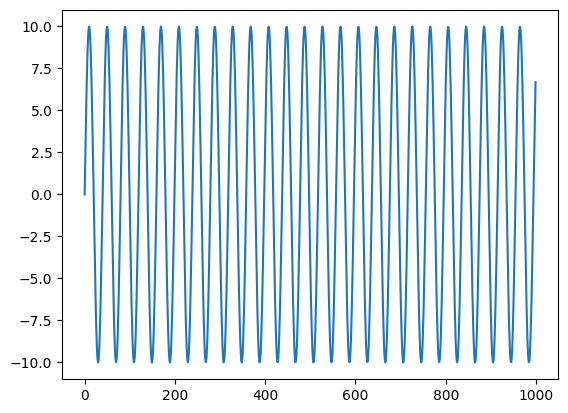

In [27]:
from IPython.display import Audio
import math
import matplotlib.pyplot as plt
import random

note_duration = 1
volume_db = 10
framerate = 44100
# Define the dataset
def convert_to_wave(index, volume_db, duration):
  t = np.linspace(0, duration, int(framerate*duration))
  frequency = 440*(2**((index-49)/12))
  return volume_db*np.sin(2*np.pi*frequency*t)

def create_wave_sequence(notes, volume_db, note_duration, combine=False):
  sine_wave = list(map(lambda x: convert_to_wave(x, volume_db, note_duration), notes))
  return np.concatenate(sine_wave) if combine else sine_wave

random_notes = [65, 65, 60, 60]
waves = create_wave_sequence(random_notes, volume_db, note_duration)
segment_length = 1000  # Show first 1000 samples
plt.plot(waves[0][:segment_length])
plt.show()

combined_waves = create_wave_sequence(random_notes, volume_db, note_duration, combine=True)
audio = Audio(combined_waves, rate=44100)
display(audio)

In [ ]:
first_sample = pd.read_csv("/content/datasets/jsb_chorales_extracted/jsb_chorales/train/chorale_004.csv").values.tolist()

first_sample_wave = create_wave_sequence([i[0] for i in first_sample], volume_db, note_duration=0.15, combine=True)
audio1 = Audio(first_sample_wave, rate=44100)
display(audio1)

In [ ]:
# Bismarck song
bismarck_notes = [
    67, 67, 67, 65, 67, 69, 67, 65, 62, 62,
    67, 67, 67, 65, 67, 69, 70, 69, 67,
    65, 65, 65, 67, 65, 64, 62,
    67, 67, 67, 65, 67, 69, 67, 65, 62, 62,
    67, 67, 67, 65, 67, 69, 70, 69, 67,
    74, 74, 72, 74, 75, 74, 72, 69, 67
]

bismarck = create_wave_sequence(bismarck_notes, volume_db, note_duration=0.3, combine=True)
audio = Audio(bismarck, rate=44100)
display(audio)

In [71]:
# Let's train the model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[None], dtype=tf.int32), # Add an Input layer with the expected shape
    tf.keras.layers.Embedding(input_dim=n_notes + 1, output_dim=5), # Increased input_dim to account for shifted values
    tf.keras.layers.Conv1D(64, kernel_size=2, padding="causal", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(128, kernel_size=3, padding="causal", activation="relu", dilation_rate=2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(128, kernel_size=3, padding="causal", activation="relu", dilation_rate=4),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(86, kernel_size=2, padding="causal", activation="relu", dilation_rate=6),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LSTM(256, return_sequences=True),
    tf.keras.layers.Dense(n_notes, activation="softmax")
])

optimizer = tf.keras.optimizers.Nadam(learning_rate=0.002)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
model.fit(train_dataset, epochs=20, validation_data=val_dataset)

Epoch 1/20


ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(None, None, 3), dtype=int32). Expected shape (None, None), but input has incompatible shape (None, None, 3)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, None, 3), dtype=int32)
  • training=True
  • mask=None
  • kwargs=<class 'inspect._empty'>